# Variant file

In [88]:
from collections import defaultdict
from pprint import pprint

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pysam
from pysam import VariantFile
import seaborn as sns

In [23]:
variants = VariantFile('data/snv-Somatic_all-972_0.vcf')

In [3]:
annotation_columns = variants.header \
    .info['ANN'] \
    .description \
    .split(':')[1] \
    .replace("'", "") \
    .split('|')
annotation_columns = tuple(map(lambda x: x.strip(), annotation_columns))

In [4]:
record = next(variants.fetch())
df = pd.DataFrame(columns=annotation_columns)
for annotation in record.info['ANN']:
    key_value_pairs = zip(annotation_columns, annotation.split('|'))
    df = df.append(dict(key_value_pairs), ignore_index=True)
df

,Allele,Annotation,Annotation_Impact,Gene_Name,Gene_ID,Feature_Type,Feature_ID,Transcript_BioType,Rank,HGVS.c,HGVS.p,cDNA.pos / cDNA.length,CDS.pos / CDS.length,AA.pos / AA.length,Distance,ERRORS / WARNINGS / INFO
0,A,stop_gained,HIGH,TP53,ENSG00000141510,transcript,ENST00000269305.8,protein_coding,8/11,c.892G>T,p.Glu298*,1082/2579,892/1182,298/393,,
1,A,stop_gained,HIGH,TP53,ENSG00000141510,transcript,ENST00000420246.6,protein_coding,8/12,c.892G>T,p.Glu298*,1025/2653,892/1026,298/341,,
2,A,stop_gained,HIGH,TP53,ENSG00000141510,transcript,ENST00000455263.6,protein_coding,8/12,c.892G>T,p.Glu298*,1025/2580,892/1041,298/346,,
3,A,stop_gained,HIGH,TP53,ENSG00000141510,transcript,ENST00000615910.4,protein_coding,8/11,c.859G>T,p.Glu287*,859/1149,859/1149,287/382,,


# Reading BAM file

In [89]:
bam = pysam.AlignmentFile('data/Deduped-972_0_sorted.bam')

In [106]:
def collect_fragment_sizes(bam_file, chromosome, start_position):
    """
    Pool fragment sizes per base at given position.
    """
    base_counts = defaultdict(list)
    
    for pile in bam_file.pileup(contig=chromosome, start=start_position):
        # We are only interested in the bases on `start_pos`.
        if pile.pos != start_position:
            continue

        for read in pile.pileups:            
            if read.is_del or read.is_refskip:
                continue

            # Skip mates.
            if read.alignment.is_paired and read.alignment.is_read2:
                continue

            base = read.alignment.query_sequence[read.query_position]
            fragment_length = abs(read.alignment.template_length)
            base_counts[base].append(fragment_length)
    
    return base_counts

In [132]:
def pool_variant_fragment_sizes():
    """
    Pool fragment sizes for nomals, and those for the variants, over all variant calls. 
    """
    normal_sizes = []
    variant_sizes = []
    
    for variant in variants.fetch():
        print('Collect fragment sizes for', variant.contig, variant.start, variant.stop)
        if variant.stop - variant.start != 1:
            raise NotImplemented
        
        base_counts = collect_fragment_sizes(
            bam, 
            chromosome=variant.contig, 
            start_position=variant.start,
        )
        
        # Pool counts for the normal.
        normals = base_counts[variant.ref.upper()]
        normal_sizes.extend(normals)
        # Pool fragment sizes for all variants.
        for alternat_base in variant.alts:
            alternats = base_counts[alternat_base.upper()]
            vaf = len(alternats)/len(normals)
            print('VAF({})'.format(alternat_base), vaf)
            variant_sizes.extend(alternats)
    return normal_sizes, variant_sizes

In [133]:
normal_sizes, variant_sizes = pool_variant_fragment_sizes()

Collect fragment sizes for chr17 7673727 7673728
VAF(A) 3.768987341772152
Collect fragment sizes for chr17 58357955 58357956
VAF(A) 0.0013415615776764154
Collect fragment sizes for chr4 54274526 54274527
VAF(T) 1.2589712918660287
Collect fragment sizes for chr9 95459699 95459700
VAF(A) 0.9145780051150895


Text(0.5, 0, 'Fragment size (bp)')

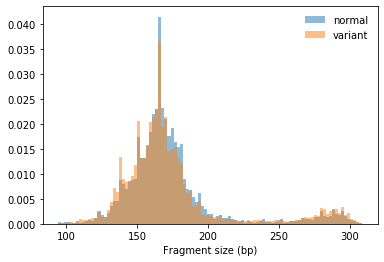

In [129]:
p_normal, bins, _ = plt.hist(
    normal_sizes, 
    bins=100, 
    density=True, 
    label='normal',
    alpha=0.5,
)
p_variant, _, _ = plt.hist(
    variant_sizes, 
    density=True, 
    bins=bins, 
    label='variant',
    alpha=0.5,
)
plt.legend(frameon=False)
plt.xlabel('Fragment size (bp)')

Text(0, 0.5, 'Enrichment (variant/normal)')

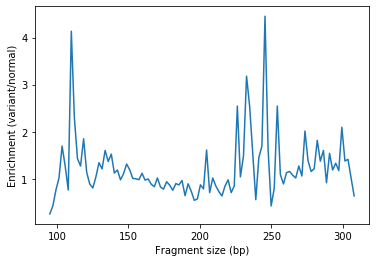

In [131]:
with np.errstate(divide='ignore'):
    enrichment = p_variant/p_normal
    enrichment[np.isnan(enrichment)] = 0

plt.plot((bins[1:] + bins[:-1])/2.0, enrichment)
plt.xlabel('Fragment size (bp)')
plt.ylabel('Enrichment (variant/normal)')